<a href="https://colab.research.google.com/github/kazuki-de/git_reserch_code/blob/master/AE_tensorflow2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

!pip install -q tensorflow-gpu==2.0.0rc0
import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation , Softmax, MaxPool2D,UpSampling2D, Input, BatchNormalization, add, AveragePooling2D,InputLayer
from tensorflow.keras import Model,Sequential
import datetime
#import tensorflow as tf
import numpy as np
import pandas as pd
#from PIL import Image
from PIL import Image
from tensorflow.keras.applications.resnet50 import ResNet50
import tensorflow_hub as hub
 
from tensorflow.keras import layers
import os
import time

import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

In [4]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
class Encode(Model):
  def __init__(self):
    super(Encode, self).__init__()
    self.conv1 = Conv2D(8,(7,7),padding="same", activation='relu', name='Conv1')
    self.pool1 = MaxPool2D((2, 2), padding='same', name='Maxpool1')
    self.conv2 = Conv2D(16,(5,5), padding="same",activation='relu', name='Conv2')
    self.pool2 = MaxPool2D((2, 2), padding='same', name='Maxpool2')
    self.conv3 = Conv2D(16,(3,3),padding="same", activation='relu', name='Conv3')
    self.pool3 = MaxPool2D((2, 2), padding='same', name='Maxpool3')
    
  def call(self, x):
    x = self.conv1(x)
    x = self.pool1(x)
    x = self.conv2(x)
    x = self.pool2(x)
    x = self.conv3(x)
    return self.pool3(x)



NameError: ignored

In [0]:
class Decode(Model):
  def __init__(self):
    super(Decode, self).__init__()
    self.conv4 = Conv2D(16,(3,3),padding="same", activation='relu', name='Conv4')
    self.uppool1 = UpSampling2D((2, 2), name='Upsumpl1')
    self.conv5 = Conv2D(16,(5,5), padding='same',activation='relu', name='Conv5')
    self.uppool2 = UpSampling2D((2, 2), name='Upsumpl2')
    self.conv6 =  Conv2D(8,(7,7), padding='same',activation='relu', name='Conv6')
    self.uppool3 = UpSampling2D((2, 2), name='Upsumpl3')
    self.conv7 = Conv2D(3,(3,3), padding='same',activation='relu', name='Conv7')
  def call(self, x):
    x = self.conv4(x)
    x = self.uppool1(x)
    x = self.conv5(x)
    x = self.uppool2(x)
    x = self.conv6(x)
    x = self.uppool3(x)
    return self.conv7(x)

In [0]:
class Autoencoder(tf.keras.Model):
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = Encode()
    self.decoder = Decode()
  
  def encode(self, x):
    return self.encoder(x)

  def  decode(self, x):
    return self.decoder(x)
    

In [0]:
model = Autoencoder()

In [10]:
model.encoder

In [0]:
def loss(pre, original):
    reconstruction_error = tf.reduce_mean(tf.square(tf.subtract(pre, original)))
    return reconstruction_error

opt = tf.keras.optimizers.Adam()
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [0]:
@tf.function
def train_step(image):
  with tf.GradientTape() as tape:
    middle = model.encode(image)
    predict = model.decode(middle)
    loss1 = loss(predict,image)
  gradients = tape.gradient(loss1, model.encoder.trainable_variables+model.decoder.trainable_variables)
  opt.apply_gradients(zip(gradients, model.encoder.trainable_variables+model.decoder.trainable_variables))

  train_loss(loss1)
  #train_accuracy(label, predictions)

In [0]:
path = "/content/drive/My Drive/2048pix_tissue_choice/sumpling_20.csv"
def generater_train():
    file_path1 = pd.read_csv("/content/drive/My Drive/256_choice/256_3000.csv")
    file_path1 = file_path1[0:2976]
    
    # LabelEncode(classをint型に変換)するためのdict\n",
    classes =["PI","PP","TRU"]
    classes = {v: i for i, v in enumerate(sorted(classes))}
    #file_path1 = pd.read_csv(file_path)
    length = len(file_path1)
    for i in range(length):
        path = file_path1.loc[i]["base_path"]
        path1 = "/content/drive/My Drive/224_choice/"+path
        with Image.open(path1) as f:
            
                tmp_image = np.asarray(f, dtype=np.float32)/255
        label = file_path1.loc[i]["type"]
        tmp_label = tf.keras.utils.to_categorical(classes[label],len(classes))
        #print(tmp_labels, np.mean(tmp_images, axis=(1,2,3)))
        yield tmp_image, tmp_label

In [0]:
TRAIN_BUF = 64
BATCH_SIZE = 32

TEST_BUF = 10000

In [0]:
dataset_t = tf.data.Dataset.from_generator(generater_train, output_types=(tf.float32, tf.int32)).batch(32).shuffle(buffer_size=2976)

In [16]:
c_dir = "/content/drive/My Drive/research_/weight_CVAE"
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, c_dir, max_to_keep=3)
ckpt.restore(manager.latest_checkpoint)

if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
    



Restored from /content/drive/My Drive/research_/weight_CVAE/ckpt-538


In [0]:
Zepochs = 500
#blunc = np.full(150, -10000)
number = 0 
epochs = 600
for epoch in range(1, epochs + 1):
    start_time = time.time()
    for batch, (x_t,x_l) in enumerate(dataset_t):
        train_step(x_t)
        #print(x_l)
        #print(x_l)
        #print(batch)
    print(epoch)    
    print(train_loss.result())
    #status.assert_consumed()  # Optional sanity checks.
    manager.save()
    #blunc[number] = elbo
    number+=1
   
        

1
tf.Tensor(0.008089272, shape=(), dtype=float32)
2
tf.Tensor(0.008078342, shape=(), dtype=float32)
3
tf.Tensor(0.008066382, shape=(), dtype=float32)
4
tf.Tensor(0.008056852, shape=(), dtype=float32)
5
tf.Tensor(0.008044044, shape=(), dtype=float32)
6
tf.Tensor(0.008032655, shape=(), dtype=float32)
7
tf.Tensor(0.008020686, shape=(), dtype=float32)
8
tf.Tensor(0.00800874, shape=(), dtype=float32)
9
tf.Tensor(0.007999008, shape=(), dtype=float32)
10
tf.Tensor(0.007987057, shape=(), dtype=float32)
11
tf.Tensor(0.007975447, shape=(), dtype=float32)
12
tf.Tensor(0.007988276, shape=(), dtype=float32)
13
tf.Tensor(0.007978245, shape=(), dtype=float32)
14
tf.Tensor(0.007967616, shape=(), dtype=float32)
15
tf.Tensor(0.0079570655, shape=(), dtype=float32)
16
tf.Tensor(0.007946198, shape=(), dtype=float32)
17
tf.Tensor(0.007935622, shape=(), dtype=float32)
18
tf.Tensor(0.007925297, shape=(), dtype=float32)
19
tf.Tensor(0.007915337, shape=(), dtype=float32)
20
tf.Tensor(0.007905447, shape=(), dtyp

In [0]:
file_path1 = pd.read_csv("/content/drive/My Drive/256_choice/256_3000.csv")

FileNotFoundError: ignored

In [0]:
file_path1 = pd.read_csv("/content/drive/My Drive/256_choice/256_3000.csv")
file_path1 =file_path1[400:410]
print(file_path1.head())
tmp_images = np.zeros((len(file_path1), 256, 256, 3))
count = 400
for i in range(10):
    path = file_path1.loc[count]["base_path"]
    print(path)
    path = "/content/drive/My Drive/256_choice/"+path
    count+=1
    with Image.open(path) as f:
        tmp_images[i] = np.asarray(f, dtype=np.float32)/255

    type  ...                                  base_path
400  TRU  ...    TRU/TCGA-75-6212-01A-01-TS1/20_5_4.jpeg
401  TRU  ...  TRU/TCGA-50-6597-01A-01-TS1/17_20_12.jpeg
402  TRU  ...    TRU/TCGA-44-7659-01A-01-BS1/14_9_4.jpeg
403  TRU  ...    TRU/TCGA-49-4512-11A-01-TS1/1_7_14.jpeg
404  TRU  ...    TRU/TCGA-71-6725-01A-01-TS1/10_6_7.jpeg

[5 rows x 6 columns]
TRU/TCGA-75-6212-01A-01-TS1/20_5_4.jpeg
TRU/TCGA-50-6597-01A-01-TS1/17_20_12.jpeg
TRU/TCGA-44-7659-01A-01-BS1/14_9_4.jpeg
TRU/TCGA-49-4512-11A-01-TS1/1_7_14.jpeg
TRU/TCGA-71-6725-01A-01-TS1/10_6_7.jpeg
PI/TCGA-73-7499-01A-01-BS1/6_2_0.jpeg
TRU/TCGA-44-6147-01A-01-BS1/2_10_10.jpeg
TRU/TCGA-71-6725-01A-01-TS1/4_4_2.jpeg
TRU/TCGA-91-7771-01A-01-TS1/11_14_13.jpeg
PI/TCGA-91-6847-01A-01-BS1/4_7_11.jpeg


In [0]:
middle = model.encode(tmp_images)
predict = model.decode(middle)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



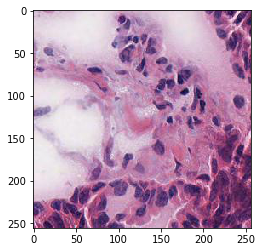

In [0]:
import matplotlib.pyplot as plt
import random
plt.imshow(tmp_images[7])
#plt.imshow(y[

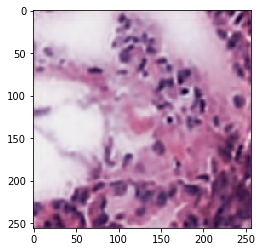

In [0]:
import matplotlib.pyplot as plt
import random
plt.imshow(predict[7])
#plt.imshow(y[